In [1]:
import os
from astropy.table import Table, vstack, Column
from astropy.io import ascii
import scipy, pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfits

/u/tmakinen/anaconda3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference


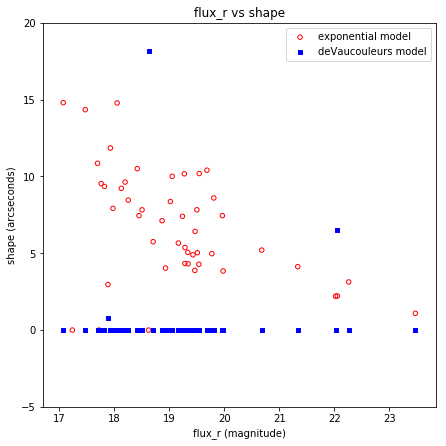

In [3]:
#------make the plot of the different lsbg shapes versus flux (in magnitude)----#
fig = plt.figure(111, figsize=(6.3, 6.3))
ax1 = pylab.subplot(111)

indxs = []



for i in range(len(lsbg_tab["flux_r"])):                             # get rid of any zero flux values
    if lsbg_tab["flux_r"][i] > 0:
        indxs.append(i)
        
exp = np.zeros(len(indxs))                                       # exponential half-light radius
dev = np.zeros(len(indxs))                                       # deVaucouleur radius
flux_mag = np.zeros(len(indxs))
        
for i in range(len(indxs)):
    exp[i] = lsbg_tab["shapeexp_r"][indxs[i]]
    dev[i] = lsbg_tab["shapedev_r"][indxs[i]]
    flux_mag[i] = 22.5 - 2.5*np.log10(lsbg_tab["flux_r"][indxs[i]]) # convert nanomaggies to flux magnitudes
 
ax1.scatter(flux_mag, exp, s=20, facecolors='none', edgecolors='r', label='exponential model')
ax1.scatter(flux_mag, dev, s=20, c = 'b', marker = "s", label = 'deVaucouleurs model')




#plt.xlim((20, 23.8))
plt.ylim((-5, 20))
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


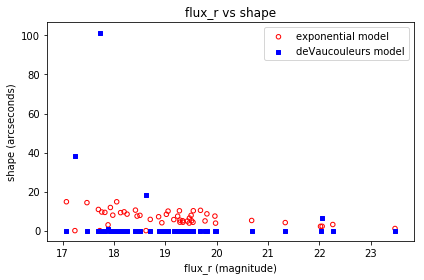

In [4]:
#------make the plot of the different lsbg shapes versus flux (in magnitude)----#
ax1 = pylab.subplot(111)



flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])

 
ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=20, facecolors='none', edgecolors='r', label='exponential model')
ax1.scatter(flux_mag, lsbg_tab['shapedev_r'], s=20, c = 'b', marker = "s", label = 'deVaucouleurs model')



#pylab.ylim([40.8, 42.0])
#pylab.xlim([])
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [48]:
import pyfits
directory = "/scratch/jgreco/tractor/191"
fname = "/scratch/jgreco/tractor/191/tractor-1914p250.fits"

t1 = pyfits.open(fname)
t2 = pyfits.open("/scratch/jgreco/tractor/191/tractor-1914p252.fits")
nrows1 = t1[1].data.shape[0]
nrows2 = t2[1].data.shape[0]
nrows = nrows1 + nrows2
hdu = pyfits.BinTableHDU.from_columns(t1[1].columns, nrows=nrows)



In [55]:
Table.read('newtable1.fits');
t1dat = t1[1].data
apflux = t1dat["apflux_r"][:,2]



AttributeError: 'numpy.ndarray' object has no attribute 'to_pandas'

In [9]:
directory = "/scratch/jgreco/tractor/191" # the directory we're going to work with
# initialize all the arrays I want to construct
flux_r = []
shapeexp_r = []
apflux_r = [] 

for fname in os.listdir(directory):     # iterate through the directory
    filename = os.fsdecode(fname)
    
    if filename.endswith(".fits"):
        #print(os.path.join(directory, filename))
        
        file = os.path.join(directory, filename)
        t2 = pyfits.open(file)         # open file using pyfits
        data = t2[1].data              # get the data from the file
        flux_r = np.concatenate((np.asarray(flux_r), data["flux_r"]), axis=0)  # assemble the big flux_r array
        shapeexp_r = np.concatenate((np.asarray(shapeexp_r), data["shapeexp_r"]), axis=0) 
        apflux_r = np.concatenate((np.asarray(apflux_r), data["apflux_r"][:,1])) # get just the 0.75 arcsec aperture mags
        


In [10]:
# Now let's put all of the arrays into a table object
# ***Note: in Astropy.Table, it's much easier to add columns side-by-side than it is to vstack rows
t = Table()
t['flux_r'] = Column(flux_r, unit='nanomaggies', description='flux_r')
t['apflux_r'] = Column(apflux_r, unit='nanomaggies', description='0.75 arcsec aperture fluxes')
t['shapeexp_r'] = Column(shapeexp_r, unit='arcsec', description = 'exponential shape half-light radius')

ascii.write(t, 'tractor191.csv', format='csv', fast_writer=False) 

In [29]:
big_table = Table.read('tractor191.csv')

In [38]:
# Make cuts to clean up the big table data

keep = (big_table['flux_r']>0.0) & (big_table['flux_r']<1e3)
keep &= (big_table['apflux_r']>0.0) & (big_table['apflux_r']<1e3)
keep &= big_table['shapeexp_r']>0

keep &= ~np.isnan(big_table['flux_r'])
keep &= ~np.isinf(big_table['flux_r'])
keep &= ~np.isnan(big_table['apflux_r'])
keep &= ~np.isinf(big_table['apflux_r'])
keep &= ~np.isnan(big_table['shapeexp_r'])
keep &= ~np.isinf(big_table['shapeexp_r'])


t = big_table[keep]

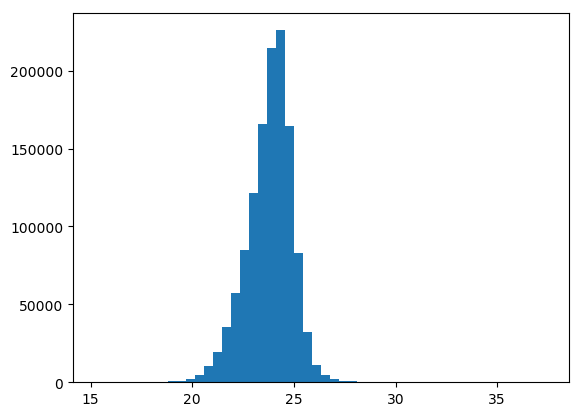

In [50]:
plt.hist(22.5 - 2.5*np.log10(t["apflux_r"]), bins=50)
plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


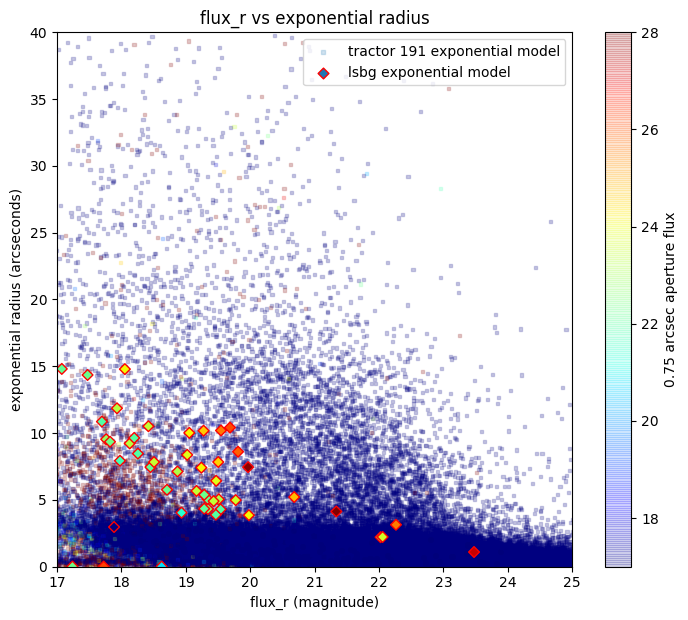

In [42]:
#------make the plot of the different lsbg shapes versus flux (in magnitude) with comparison objects----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# convert out of nanomaggies (lol) #
flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
tractor_flux = 22.5 - 2.5*np.log10(t['flux_r'])

# get lsbg aperture fluxes for 0.75 arcsec aperture
lsbg_apflux = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,1])

# create colorbar for aperture fluxes. This is essentially the objects' luminosity profiles
cbar = 22.5 - 2.5*np.log10(t['apflux_r'])        # use big tractor file for colorbar range
cbarnorm = cbar / cbar.max()        # normalize colorbar to be able to use cool presets

uplim = 17                         # set upper and lower limits for color bar (+3 std dev)
lowlim = 28 

# make cut based on apflux -- indexes where apflux > 20
#cut_indx = np.argwhere(t['apflux_r']>20)


# make scatterplots 
sctrac = ax1.scatter(tractor_flux, t['shapeexp_r'], s=5, c = t['apflux_r'], marker = "s", cmap=plt.cm.jet, alpha=0.2, label = 'tractor 191 exponential model')

sc = ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=30, c = lsbg_apflux, marker='D', cmap=plt.cm.jet, alpha=1, edgecolors='r', label='lsbg exponential model')



plt.xlim((17, 25))
plt.ylim((0, 40))
plt.title('flux_r vs exponential radius')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('exponential radius (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()
sctrac.set_clim([lowlim, uplim])
colorbar = plt.colorbar(sctrac)

colorbar.set_label('0.75 arcsec aperture flux', rotation=90)



plt.show()

In [ ]:
#------make the plot of the different lsbg shapes versus flux (in magnitude) with comparison objects----#
plt.style.use('default')
fig = plt.figure(221, figsize=(6.3, 7.3))
ax1 = plt.subplot(111)


# convert out of nanomaggies (lol) #
flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
tractor_flux = 22.5 - 2.5*np.log10(big_table['flux_r'])

# get lsbg aperture fluxes for 0.75 arcsec aperture
lsbg_apflux = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,1])

# create colorbar for aperture fluxes. This is essentially the objects' luminosity profiles
cbar = 22.5 - 2.5*np.log10(big_table['apflux_r'])        # use big tractor file for colorbar range
cbarnorm = cbar / cbar.max()        # normalize colorbar to be able to use cool presets

uplim = 28                         # set upper and lower limits for color bar (+3 std dev)
lowlim = 17 

# make cuts based on 


# make scatterplots 
sctrac = ax1.scatter(tractor_flux, big_table['shapeexp_r'], s=5, c = big_table['apflux_r'], marker = "s", cmap=plt.cm.jet, alpha=0.2, label = 'tractor 191 exponential model')

sc = ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=30, c = lsbg_apflux, marker='D', cmap=plt.cm.jet, alpha=1, edgecolors='r', label='lsbg exponential model')



plt.xlim((17, 25))
plt.ylim((0, 40))
plt.title('flux_r vs exponential radius')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('exponential radius (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()
sctrac.set_clim([lowlim, uplim])
colorbar = plt.colorbar(sctrac)

colorbar.set_label('0.75 arcsec aperture flux', rotation=90)



plt.show()

In [54]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import math

#------make the plot of the different lsbg shapes versus flux (in magnitude) with comparison objects and side histograms----#

# convert out of nanomaggies (lol) #
lsbg_flux = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])           # flux
lsbg_apflux = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,1])  # aperture flux

lsbg_f = lsbg_flux[~np.isnan(lsbg_flux)]
lsbg_af = lsbg_apflux[~np.isnan(lsbg_apflux)]



tractor_flux = 22.5 - 2.5*np.log10(big_table['flux_r'])
tractor_apflux = 22.5 - 2.5*np.log10(big_table['apflux_r'])

tf = tractor_flux[~np.isnan(tractor_flux)]                     # NaNs removed
taf = tractor_apflux[~np.isnan(tractor_apflux)]                 
tf[np.isinf(tf)] = 0.0                                         # infs removed
taf[np.isinf(taf)] = 0.0

    


# create colorbar for aperture fluxes. This is essentially the objects' luminosity profiles
cbar = tractor_apflux               # use big tractor file for colorbar range
cbarnorm = cbar / cbar.max()        # normalize colorbar to be able to use cool presets
uplim = 28                          # set upper and lower limits for color bar (+3 std dev)
lowlim = 17 




# Calculate number of bins based on binsize for both x and y

# For tractor data
min_x_data, max_x_data = 17, 26
binsize = 0.2
num_x_bins = np.floor((max_x_data - min_x_data) / binsize)


min_y_data, max_y_data = np.min(big_table['shapeexp_r']), np.max(big_table['shapeexp_r'])
binsize = 0.2
num_y_bins = np.floor((max_y_data - min_y_data) / binsize)


# Axes definitions
nullfmt = plt.NullFormatter()
left, width = 0.1, 0.4
bottom, height = 0.1, 0.4
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.4]
rect_histy = [left_h, bottom, 0.4, height]


# Generate initial figure, scatter plot, and histogram quadrants
fig = plt.figure(221, figsize=(6.3, 6.3))

# Make ax1 our scatter axis
ax1 = fig.add_subplot(223, position=rect_scatter)
ax1.set_xlabel('flux_r')
ax1.set_ylabel('exponential radius')
ax1.set_xlim(17., 25.)
ax1.set_ylim(0., 40.)

# add the histograms to the sides
axHistX = fig.add_subplot(221, position=rect_histx)
axHistX.set_xlim(17., 25.)
axHistX.set_ylim(0, 10000000.)

axHistY = fig.add_subplot(224, position=rect_histy)
axHistY.set_xlim(0, 10000000.)
axHistY.set_ylim(0., 40.)

# Remove labels from histogram edges touching scatter plot
axHistX.xaxis.set_major_formatter(nullfmt)
axHistY.yaxis.set_major_formatter(nullfmt)

# make the scatterplot
sctrac = ax1.scatter(tractor_flux, big_table['shapeexp_r'], s=5, c = big_table['apflux_r'], marker = "s", cmap=plt.cm.jet, label = 'tractor 191 exponential model')
sc = ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=30, c = lsbg_apflux, marker='D', cmap=plt.cm.jet, edgecolors='r', label='lsbg exponential model')



# make the x-axis histogram
axHistX.hist(tf, num_x_bins, ec='green', fc='none', histtype='bar')


# Draw y-axis histogram
axHistY.hist(big_table["shapeexp_r"], num_y_bins, ec='green', fc='none', histtype='step', orientation='horizontal')


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('flux_r (magnitude)')
ax_joint.set_ylabel('exponential r_1/2 (arcsecs)')

# Set labels on marginals
ax_marg_y.set_xlabel('flux_r (magnitude)')
ax_marg_x.set_ylabel('exponential r_1/2 (arcsecs)')




plt.title('flux_r vs shape')
plt.legend(loc='best')
plt.tight_layout()
sctrac.set_clim([lowlim, uplim])
plt.colorbar(sctrac)






plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [48]:
tractor_flux = 22.5 - 2.5*np.log10(big_table['flux_r'])
tractor_apflux = 22.5 - 2.5*np.log10(big_table['apflux_r'])

tf = tractor_flux[~np.isnan(tractor_flux)]                     # 1D array with NaNs removed
taf = tractor_apflux[~np.isnan(tractor_apflux)]

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [51]:
tf[np.isinf(tf)] = 0.0
np.max(tf)

36.195498947533999

In [42]:
#------make the plot of the different lsbg shapes versus flux (in magnitude) with comparison objects and side histograms----#

# convert out of nanomaggies (lol) #
flux_mag = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
tractor_flux = 22.5 - 2.5*np.log10(big_table['flux_r'])
# get lsbg aperture fluxes for 0.75 arcsec aperture
lsbg_apflux = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,1])
# create colorbar for aperture fluxes. This is essentially the objects' luminosity profiles
cbar = 22.5 - 2.5*np.log10(big_table['apflux_r'])        # use big tractor file for colorbar range
cbarnorm = cbar / cbar.max()        # normalize colorbar to be able to use cool presets
uplim = 28                         # set upper and lower limits for color bar (+3 std dev)
lowlim = 17 


# plot parameters

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]    # scatterplot rectangle
rect_histx = [left, bottom_h, width, 0.2]       # histogram rectangles
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
ax1 = plt.axes(rect_scatter)    # scatter axis
axHistx = plt.axes(rect_histx)  # histogram axes
axHisty = plt.axes(rect_histy)


# make scatterplots 
sctrac = ax1.scatter(tractor_flux, big_table['shapeexp_r'], s=5, c = big_table['apflux_r'], marker = "s", cmap=plt.cm.jet, label = 'tractor 191 exponential model')
sc = ax1.scatter(flux_mag, lsbg_tab['shapeexp_r'], s=30, c = lsbg_apflux, marker='D', cmap=plt.cm.jet, edgecolors='r', label='lsbg exponential model')


# make histograms
# now determine nice limits by hand:
binwidth = 0.25


ax1.set_xlim((17, 25))
ax1.set_ylim((0, 40))

bins = np.arange(17, 25 + binwidth, binwidth)
# flux_r histogram
axHistx.hist(tractor_flux, bins=bins)
axHistx.hist(flux_mag, bins=bins)
                   
# shape histogram
axHisty.hist(big_table['shapeexp_r'], bins=bins, orientation='horizontal')
axHisty.hist(lsbg_tab['shapeexp_r'], bins=bins, orientation='horizontal')

axHistx.set_xlim(ax1.get_xlim())
axHisty.set_ylim(ax1.get_ylim())

                   
                   
plt.title('flux_r vs shape')
plt.xlabel('flux_r (magnitude)')
plt.ylabel('shape (arcseconds)')

plt.legend(loc='best')
plt.tight_layout()
sctrac.set_clim([lowlim, uplim])
plt.colorbar(sctrac)


plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


ValueError: range parameter must be finite.

array([ True], dtype=bool)

In [ ]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference

In [23]:
os.listdir('/scratch/jgreco/tractor/343')

In [9]:
ascii.write(lsbg_tab, 'legacy-data.csv', format='csv', fast_writer=False, overwrite=True)

In [ ]:
brick = "3376m005"
objid = 5738

In [58]:
trctr = brick[0:3]   #take out the first three digits of the brick to get the tractor number

In [59]:
fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
print(fname)

/scratch/jgreco/tractor/337/tractor-3376m005.fits


In [60]:
tab = Table.read(fname)

In [61]:
tab[objid]


release,brickid,brickname,objid,brick_primary,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq [5],ebv,mjd_min,mjd_max,flux_u,flux_g,flux_r,flux_i,flux_z,flux_Y,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_u,flux_ivar_g,flux_ivar_r,flux_ivar_i,flux_ivar_z,flux_ivar_Y,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,apflux_u [8],apflux_g [8],apflux_r [8],apflux_i [8],apflux_z [8],apflux_Y [8],apflux_resid_u [8],apflux_resid_g [8],apflux_resid_r [8],apflux_resid_i [8],apflux_resid_z [8],apflux_resid_Y [8],apflux_ivar_u [8],apflux_ivar_g [8],apflux_ivar_r [8],apflux_ivar_i [8],apflux_ivar_z [8],apflux_ivar_Y [8],mw_transmission_u,mw_transmission_g,mw_transmission_r,mw_transmission_i,mw_transmission_z,mw_transmission_Y,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_u,nobs_g,nobs_r,nobs_i,nobs_z,nobs_Y,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_u,rchisq_g,rchisq_r,rchisq_i,rchisq_z,rchisq_Y,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_u,fracflux_g,fracflux_r,fracflux_i,fracflux_z,fracflux_Y,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_u,fracmasked_g,fracmasked_r,fracmasked_i,fracmasked_z,fracmasked_Y,fracin_u,fracin_g,fracin_r,fracin_i,fracin_z,fracin_Y,anymask_u,anymask_g,anymask_r,anymask_i,anymask_z,anymask_Y,allmask_u,allmask_g,allmask_r,allmask_i,allmask_z,allmask_Y,wisemask_w1,wisemask_w2,psfsize_u,psfsize_g,psfsize_r,psfsize_i,psfsize_z,psfsize_Y,psfdepth_u,psfdepth_g,psfdepth_r,psfdepth_i,psfdepth_z,psfdepth_Y,galdepth_u,galdepth_g,galdepth_r,galdepth_i,galdepth_z,galdepth_Y,wise_coadd_id,lc_flux_w1 [7],lc_flux_w2 [7],lc_flux_ivar_w1 [7],lc_flux_ivar_w2 [7],lc_nobs_w1 [7],lc_nobs_w2 [7],lc_fracflux_w1 [7],lc_fracflux_w2 [7],lc_rchisq_w1 [7],lc_rchisq_w2 [7],lc_mjd_w1 [7],lc_mjd_w2 [7],fracdev,fracdev_ivar,shapeexp_r,shapeexp_r_ivar,shapeexp_e1,shapeexp_e1_ivar,shapeexp_e2,shapeexp_e2_ivar,shapedev_r,shapedev_r_ivar,shapedev_e1,shapedev_e1_ivar,shapedev_e2,shapedev_e2_ivar
,,,,,,deg,deg,1/deg^2,1/deg^2,,,,mag,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,arcsec,arcsec,arcsec,arcsec,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,arcsec,1/arcsec^2,,,,,arcsec,1/arcsec^2,,,,
int16,int32,str8,int32,bool,str4,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,flo